# Previsão de Churn na Telecom X

Este notebook contém a análise completa para prever a evasão (churn) de clientes da Telecom X.

## Objetivos:
- Preparar os dados para modelagem
- Realizar análise exploratória
- Treinar modelos de classificação
- Avaliar o desempenho dos modelos
- Interpretar os resultados

## 1. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configurações de visualização
plt.style.use('default')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Carregamento e Pré-processamento dos Dados

In [2]:
# Carregar os dados
file_path = '../data/TelecomX_Data.json'
df = pd.read_json(file_path)

print("Primeiras 5 linhas do DataFrame original:")
print(df.head())
print(f"\nShape dos dados: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")

Primeiras 5 linhas do DataFrame original:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService

In [3]:
# Função para achatar colunas JSON aninhadas
def flatten_json_col(df, col_name):
    col_df = pd.json_normalize(df[col_name])
    df = df.drop(col_name, axis=1)
    df = pd.concat([df, col_df], axis=1)
    return df

# Achatar as colunas aninhadas
df = flatten_json_col(df, 'customer')
df = flatten_json_col(df, 'phone')
df = flatten_json_col(df, 'internet')

# Achatar a coluna 'account' primeiro para acessar 'Charges'
df_account = pd.json_normalize(df['account'])
df = df.drop('account', axis=1)
df = pd.concat([df, df_account], axis=1)

# Renomear as colunas 'Charges.Monthly' e 'Charges.Total'
df = df.rename(columns={'Charges.Monthly': 'MonthlyCharges', 'Charges.Total': 'TotalCharges'})

print("Colunas após o pré-processamento:")
print(df.columns.tolist())

Colunas após o pré-processamento:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [4]:
# Remover a coluna de ID do cliente
df = df.drop('customerID', axis=1)

# Tratar valores ausentes na coluna 'Churn'
df['Churn'] = df['Churn'].replace('', 'No')

# Converter a coluna 'TotalCharges' para numérica
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print("Verificando valores nulos após limpeza:")
print(df.isnull().sum())

print("\nDistribuição da variável target (Churn):")
print(df['Churn'].value_counts())

Verificando valores nulos após limpeza:
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Distribuição da variável target (Churn):
Churn
No     5398
Yes    1869
Name: count, dtype: int64


C:\Users\mauro\AppData\Local\Temp\ipykernel_27160\2951965380.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [5]:
# Codificar variáveis categóricas usando one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Shape após encoding: {df_encoded.shape}")
print("\nPrimeiras 5 linhas do DataFrame processado:")
print(df_encoded.head())

Shape após encoding: (7267, 31)

Primeiras 5 linhas do DataFrame processado:
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn_Yes  \
0              0       9            65.6        593.30      False   
1              0       9            59.9        542.40      False   
2              0       4            73.9        280.85       True   
3              1      13            98.0       1237.85       True   
4              1       3            83.9        267.40       True   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0        False         True            True              True   
1         True        False           False              True   
2         True        False           False              True   
3         True         True           False              True   
4        False         True           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                           False  ...    

## 3. Análise Exploratória dos Dados

Proporção de Churn:
Não churn (0): 5398 (74.28%)
Churn (1): 1869 (25.72%)


C:\Users\mauro\AppData\Local\Temp\ipykernel_27160\3557175021.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Não churn (0): {churn_counts[0]} ({churn_counts[0]/len(df_encoded)*100:.2f}%)")
C:\Users\mauro\AppData\Local\Temp\ipykernel_27160\3557175021.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Churn (1): {churn_counts[1]} ({churn_counts[1]/len(df_encoded)*100:.2f}%)")


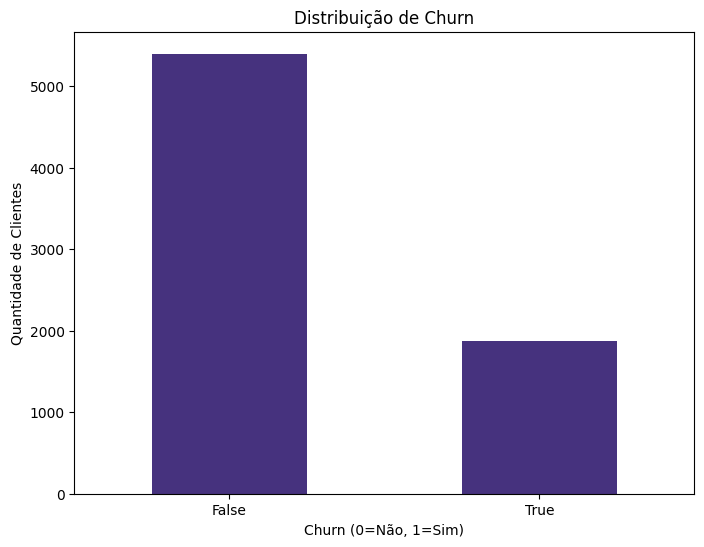

In [6]:
# Verificar a proporção de churn
churn_counts = df_encoded['Churn_Yes'].value_counts()
print("Proporção de Churn:")
print(f"Não churn (0): {churn_counts[0]} ({churn_counts[0]/len(df_encoded)*100:.2f}%)")
print(f"Churn (1): {churn_counts[1]} ({churn_counts[1]/len(df_encoded)*100:.2f}%)")

# Visualizar a distribuição de churn
plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar')
plt.title('Distribuição de Churn')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Quantidade de Clientes')
plt.xticks(rotation=0)
plt.show()

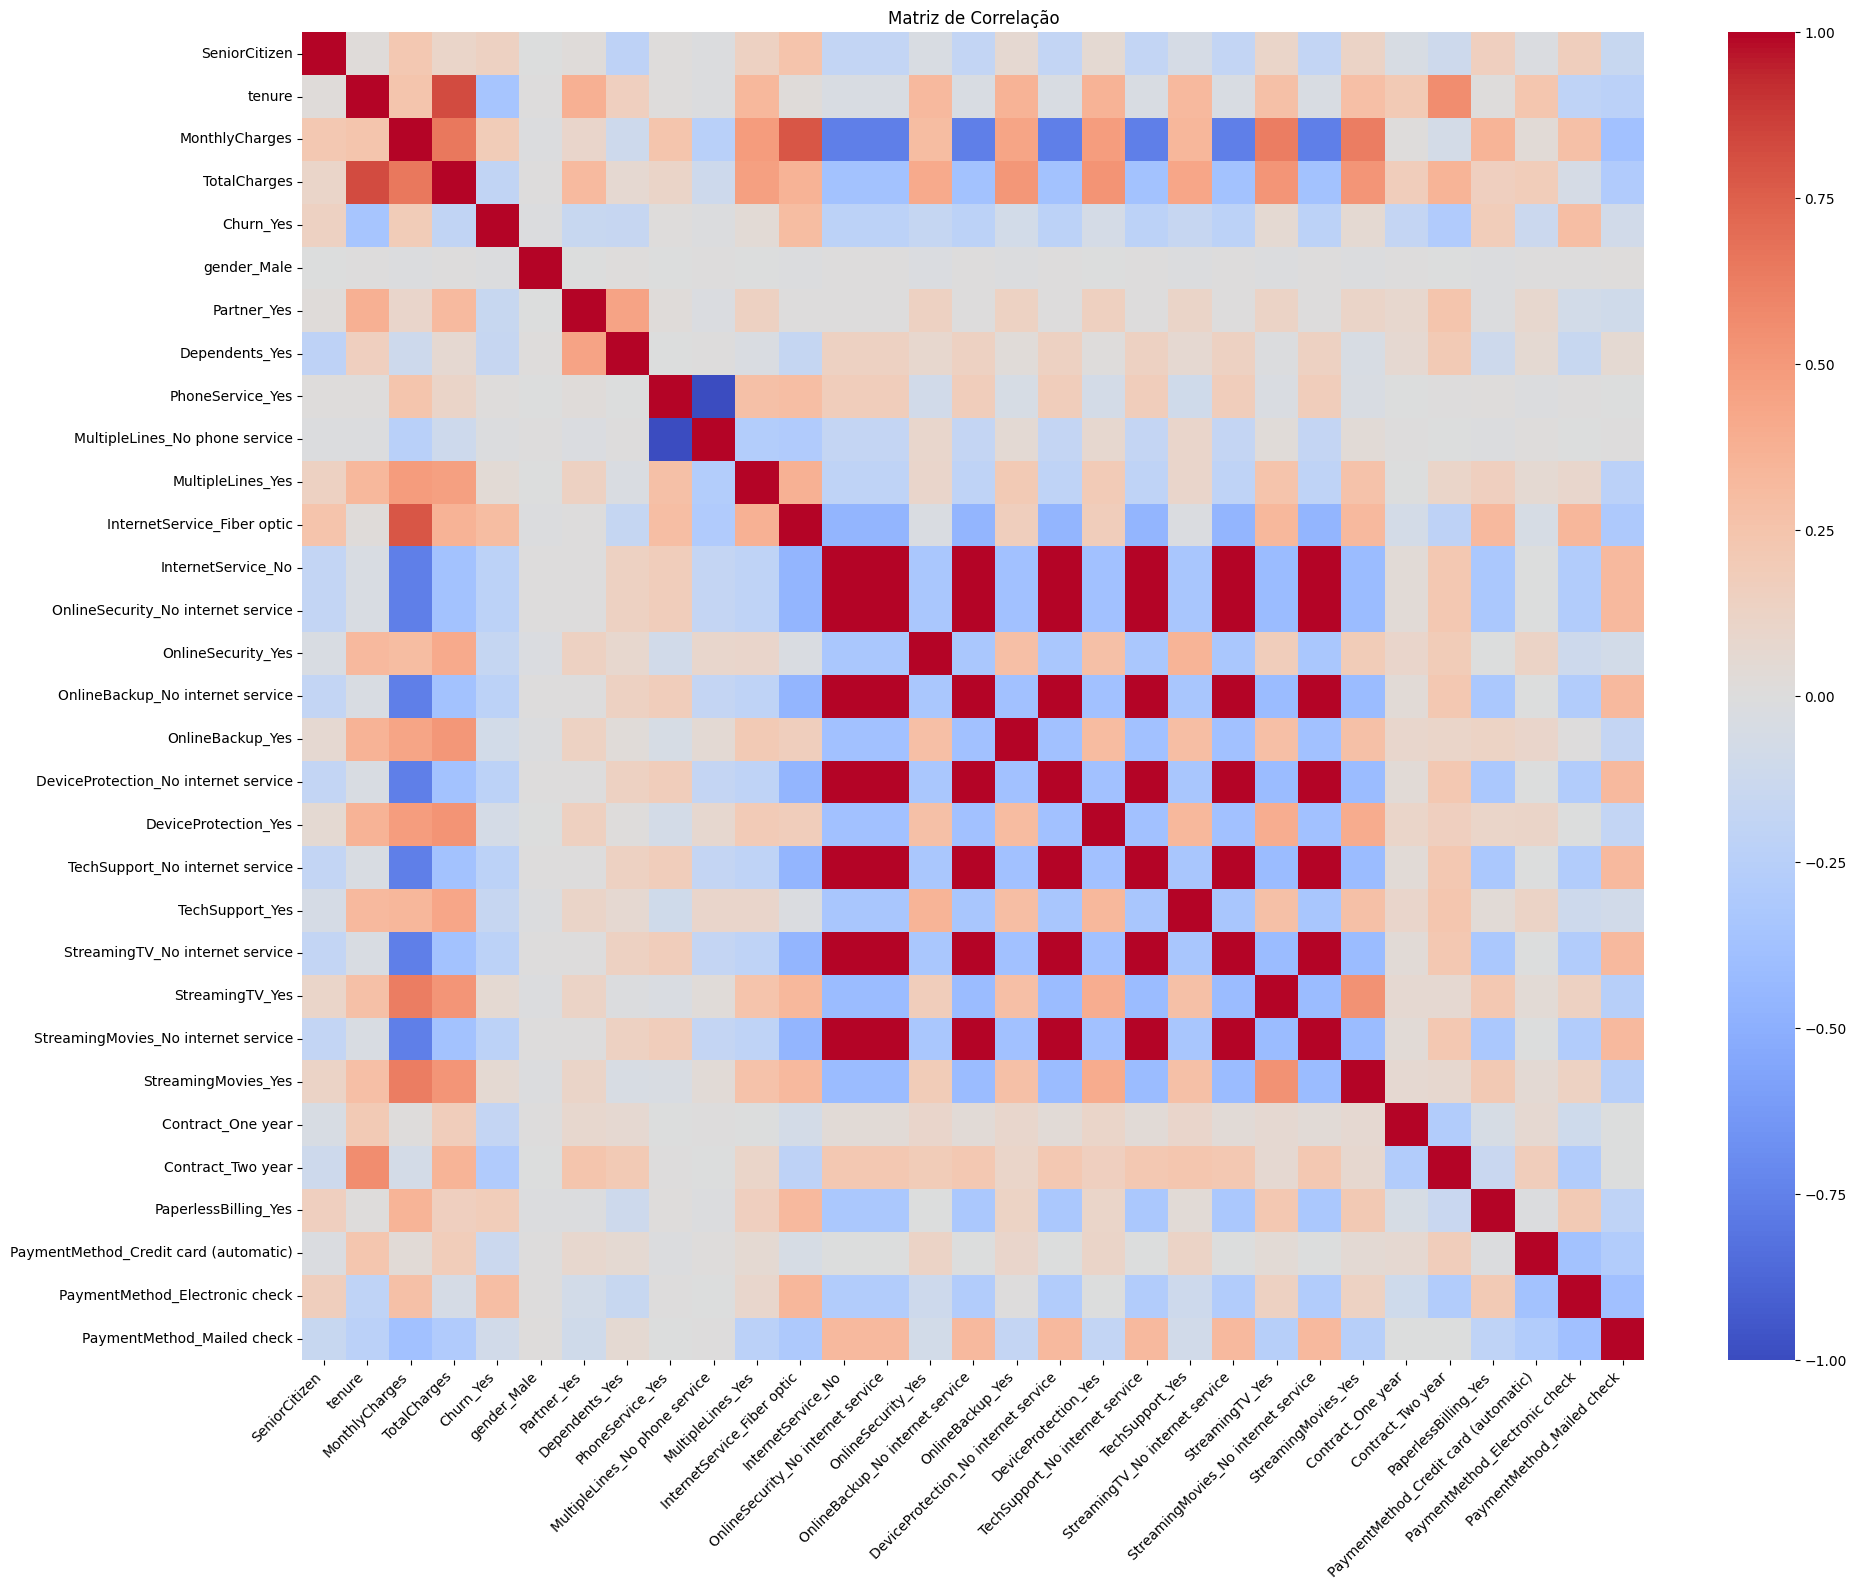

In [7]:
# Calcular a matriz de correlação
correlation_matrix = df_encoded.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Top 15 correlações positivas com Churn:
InternetService_Fiber optic              0.300949
PaymentMethod_Electronic check           0.294626
MonthlyCharges                           0.189866
PaperlessBilling_Yes                     0.186666
SeniorCitizen                            0.146733
StreamingTV_Yes                          0.062430
StreamingMovies_Yes                      0.060586
MultipleLines_Yes                        0.039343
PhoneService_Yes                         0.012571
gender_Male                             -0.009555
MultipleLines_No phone service          -0.012571
DeviceProtection_Yes                    -0.063452
OnlineBackup_Yes                        -0.080163
PaymentMethod_Mailed check              -0.090061
PaymentMethod_Credit card (automatic)   -0.131085
Name: Churn_Yes, dtype: float64

Top 15 correlações negativas com Churn:
Partner_Yes                            -0.148546
TechSupport_Yes                        -0.160440
Dependents_Yes                         

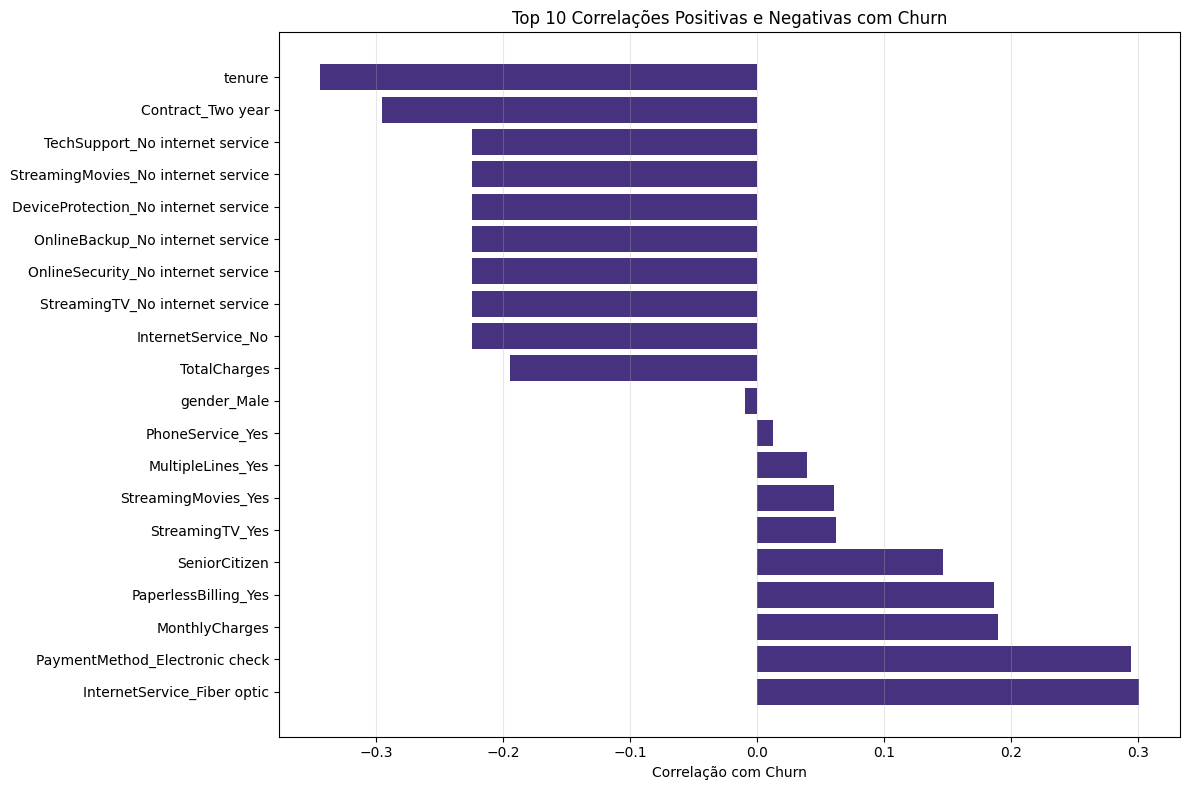

In [8]:
# Correlação com Churn
churn_corr = correlation_matrix['Churn_Yes'].sort_values(ascending=False)
churn_corr = churn_corr[churn_corr.index != 'Churn_Yes']  # Remove a própria variável

print("Top 15 correlações positivas com Churn:")
print(churn_corr.head(15))
print("\nTop 15 correlações negativas com Churn:")
print(churn_corr.tail(15))

# Visualizar as correlações mais importantes
top_corr = churn_corr.head(10)
bottom_corr = churn_corr.tail(10)
combined_corr = pd.concat([top_corr, bottom_corr])

plt.figure(figsize=(12, 8))
plt.barh(range(len(combined_corr)), combined_corr.values)
plt.yticks(range(len(combined_corr)), combined_corr.index)
plt.xlabel('Correlação com Churn')
plt.title('Top 10 Correlações Positivas e Negativas com Churn')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

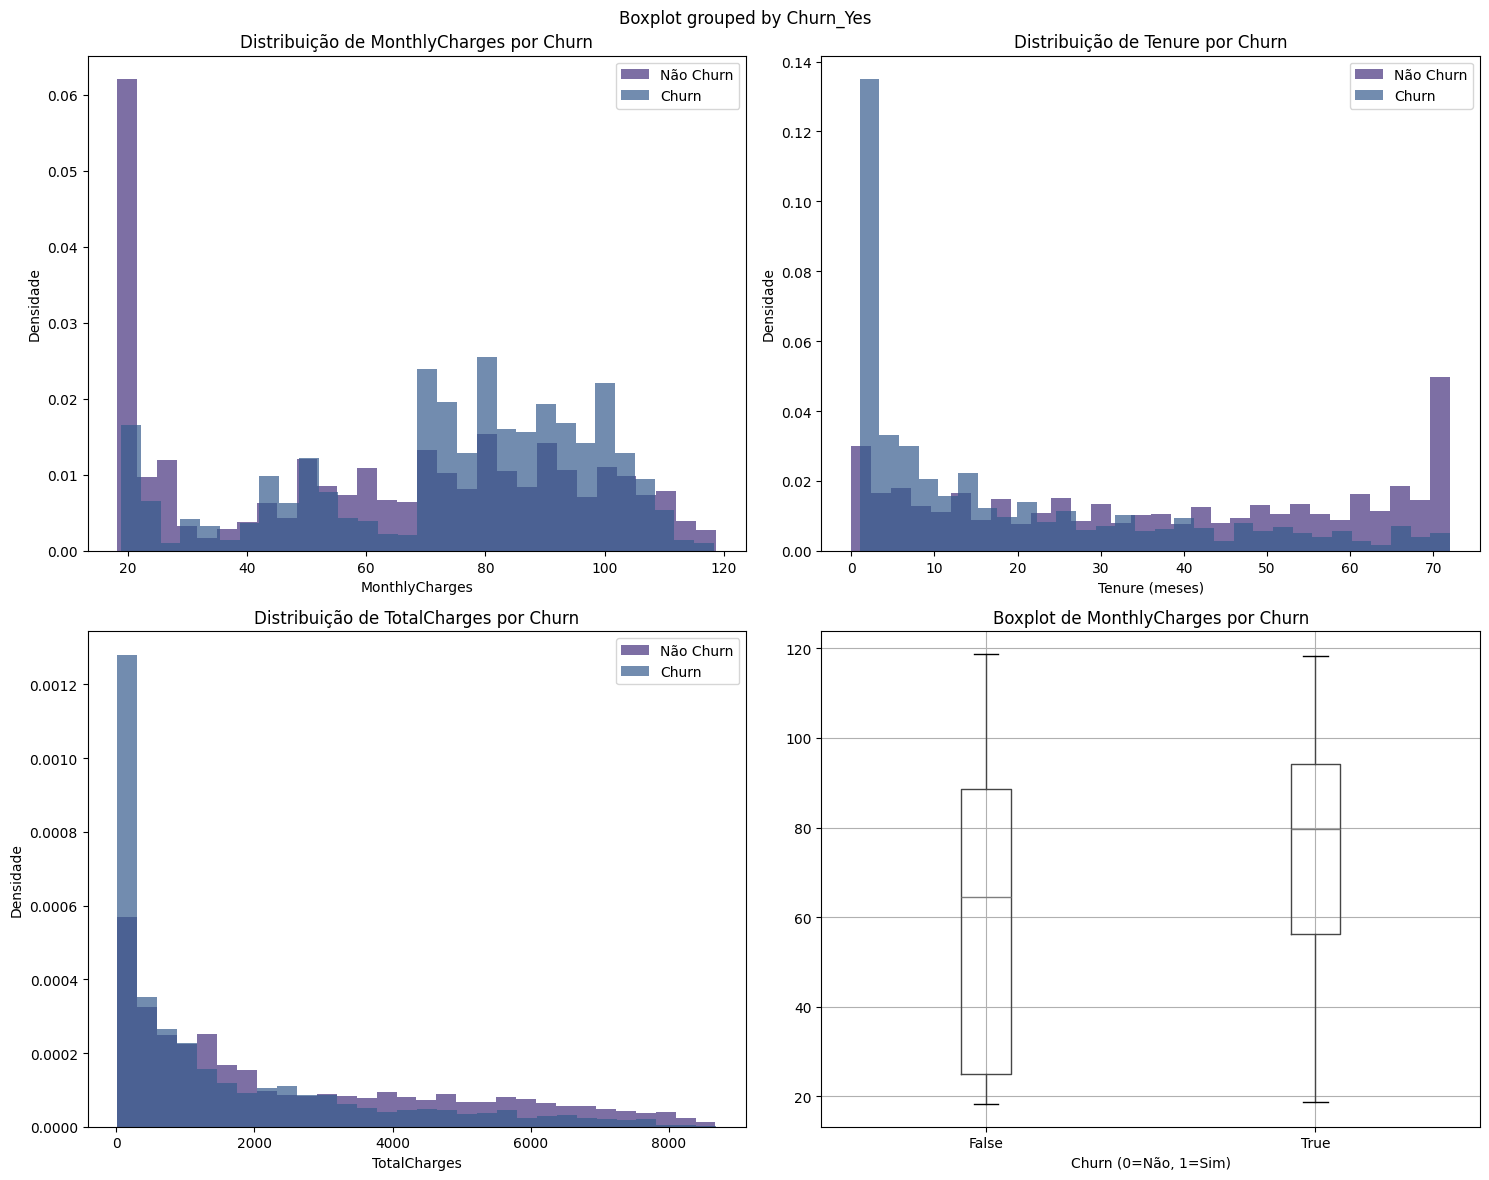

In [9]:
# Análise de variáveis específicas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribuição de MonthlyCharges por Churn
churn_0 = df_encoded[df_encoded['Churn_Yes'] == 0]['MonthlyCharges']
churn_1 = df_encoded[df_encoded['Churn_Yes'] == 1]['MonthlyCharges']
axes[0, 0].hist(churn_0, alpha=0.7, label='Não Churn', bins=30, density=True)
axes[0, 0].hist(churn_1, alpha=0.7, label='Churn', bins=30, density=True)
axes[0, 0].set_xlabel('MonthlyCharges')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].set_title('Distribuição de MonthlyCharges por Churn')
axes[0, 0].legend()

# Distribuição de tenure por Churn
churn_0_tenure = df_encoded[df_encoded['Churn_Yes'] == 0]['tenure']
churn_1_tenure = df_encoded[df_encoded['Churn_Yes'] == 1]['tenure']
axes[0, 1].hist(churn_0_tenure, alpha=0.7, label='Não Churn', bins=30, density=True)
axes[0, 1].hist(churn_1_tenure, alpha=0.7, label='Churn', bins=30, density=True)
axes[0, 1].set_xlabel('Tenure (meses)')
axes[0, 1].set_ylabel('Densidade')
axes[0, 1].set_title('Distribuição de Tenure por Churn')
axes[0, 1].legend()

# Distribuição de TotalCharges por Churn
churn_0_total = df_encoded[df_encoded['Churn_Yes'] == 0]['TotalCharges']
churn_1_total = df_encoded[df_encoded['Churn_Yes'] == 1]['TotalCharges']
axes[1, 0].hist(churn_0_total, alpha=0.7, label='Não Churn', bins=30, density=True)
axes[1, 0].hist(churn_1_total, alpha=0.7, label='Churn', bins=30, density=True)
axes[1, 0].set_xlabel('TotalCharges')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].set_title('Distribuição de TotalCharges por Churn')
axes[1, 0].legend()

# Boxplot de MonthlyCharges por Churn
df_encoded.boxplot(column='MonthlyCharges', by='Churn_Yes', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot de MonthlyCharges por Churn')
axes[1, 1].set_xlabel('Churn (0=Não, 1=Sim)')

plt.tight_layout()
plt.show()

## 4. Desenvolvimento dos Modelos de Machine Learning

In [10]:
# Separar features (X) e target (y)
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

print(f"Shape das features: {X.shape}")
print(f"Shape do target: {y.shape}")

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nShape do conjunto de treino: {X_train.shape}")
print(f"Shape do conjunto de teste: {X_test.shape}")

Shape das features: (7267, 30)
Shape do target: (7267,)

Shape do conjunto de treino: (5086, 30)
Shape do conjunto de teste: (2181, 30)


In [11]:
# Normalização dos dados para modelos sensíveis à escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados normalizados com sucesso!")
print(f"Média das features normalizadas (treino): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Desvio padrão das features normalizadas (treino): {X_train_scaled.std(axis=0)[:5]}")

Dados normalizados com sucesso!
Média das features normalizadas (treino): [-5.97241486e-17 -1.22242409e-16  2.36102482e-16  1.94889327e-16
  1.30974010e-16]
Desvio padrão das features normalizadas (treino): [1. 1. 1. 1. 1.]


In [12]:
# Modelo 1: Regressão Logística (sensível à escala)
print("Treinando Regressão Logística...")
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

print("Regressão Logística treinada com sucesso!")

Treinando Regressão Logística...
Regressão Logística treinada com sucesso!


In [13]:
# Modelo 2: Random Forest (não sensível à escala)
print("Treinando Random Forest...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest treinado com sucesso!")

Treinando Random Forest...
Random Forest treinado com sucesso!


## 5. Avaliação dos Modelos


--- Avaliação do Modelo: Regressão Logística ---
Acurácia: 0.8010
Precisão: 0.6348
Recall: 0.5330
F1-Score: 0.5795
Matriz de Confusão:
[[1448  172]
 [ 262  299]]


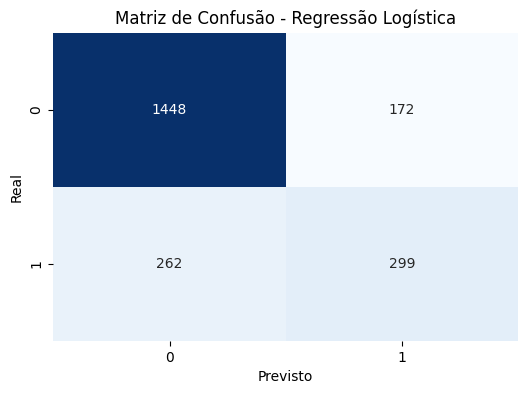


--- Avaliação do Modelo: Random Forest ---
Acurácia: 0.7840
Precisão: 0.6004
Recall: 0.4795
F1-Score: 0.5332
Matriz de Confusão:
[[1441  179]
 [ 292  269]]


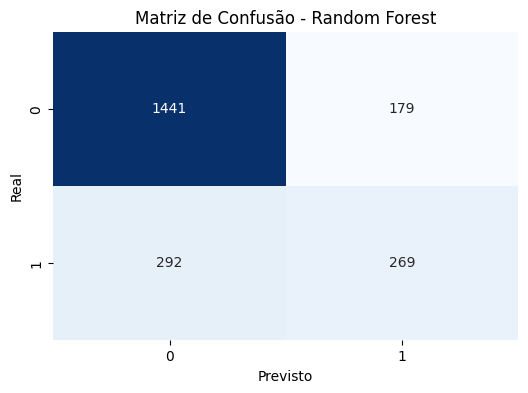

In [14]:
# Função para avaliar e imprimir métricas
def evaluate_model(model_name, y_true, y_pred):
    print(f"\n--- Avaliação do Modelo: {model_name} ---")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    
    # Visualizar matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()
    
    return {
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Avaliar os modelos
log_reg_metrics = evaluate_model("Regressão Logística", y_test, y_pred_log_reg)
rf_metrics = evaluate_model("Random Forest", y_test, y_pred_rf)


--- Comparação dos Modelos ---
                Modelo  Acurácia  Precisão    Recall  F1-Score
0  Regressão Logística  0.801009  0.634820  0.532977  0.579457
1        Random Forest  0.784044  0.600446  0.479501  0.533201


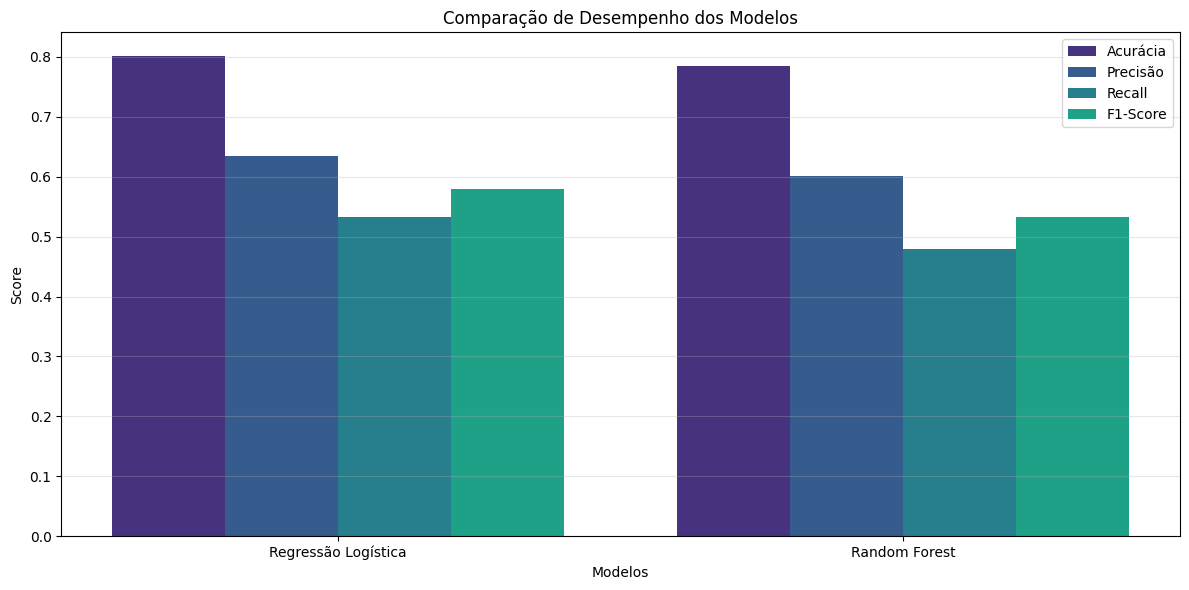

In [15]:
# Comparação dos modelos
models_comparison = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest'],
    'Acurácia': [log_reg_metrics['Acurácia'], rf_metrics['Acurácia']],
    'Precisão': [log_reg_metrics['Precisão'], rf_metrics['Precisão']],
    'Recall': [log_reg_metrics['Recall'], rf_metrics['Recall']],
    'F1-Score': [log_reg_metrics['F1-Score'], rf_metrics['F1-Score']]
})

print("\n--- Comparação dos Modelos ---")
print(models_comparison)

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models_comparison['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, models_comparison['Acurácia'], width, label='Acurácia')
ax.bar(x - 0.5*width, models_comparison['Precisão'], width, label='Precisão')
ax.bar(x + 0.5*width, models_comparison['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, models_comparison['F1-Score'], width, label='F1-Score')

ax.set_xlabel('Modelos')
ax.set_ylabel('Score')
ax.set_title('Comparação de Desempenho dos Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models_comparison['Modelo'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análise da Importância das Variáveis

In [16]:
# Regressão Logística - Coeficientes
feature_names = X.columns
log_reg_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_model.coef_[0]
})
log_reg_coef['Abs_Coefficient'] = np.abs(log_reg_coef['Coefficient'])
log_reg_coef_sorted = log_reg_coef.sort_values('Abs_Coefficient', ascending=False)

print("\nRegressão Logística - Top 10 Coeficientes (Importância):")
print(log_reg_coef_sorted.head(10))


Regressão Logística - Top 10 Coeficientes (Importância):
                        Feature  Coefficient  Abs_Coefficient
1                        tenure    -1.352980         1.352980
2                MonthlyCharges    -0.884210         0.884210
10  InternetService_Fiber optic     0.720018         0.720018
3                  TotalCharges     0.633315         0.633315
25            Contract_Two year    -0.538821         0.538821
24            Contract_One year    -0.270463         0.270463
23          StreamingMovies_Yes     0.252493         0.252493
21              StreamingTV_Yes     0.228720         0.228720
9             MultipleLines_Yes     0.202155         0.202155
26         PaperlessBilling_Yes     0.189535         0.189535


In [17]:
# Random Forest - Importância das Features
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})
rf_importance_sorted = rf_importance.sort_values('Importance', ascending=False)

print("\nRandom Forest - Top 10 Features Mais Importantes:")
print(rf_importance_sorted.head(10))


Random Forest - Top 10 Features Mais Importantes:
                           Feature  Importance
3                     TotalCharges    0.196160
2                   MonthlyCharges    0.172604
1                           tenure    0.166648
28  PaymentMethod_Electronic check    0.037858
10     InternetService_Fiber optic    0.037012
4                      gender_Male    0.030186
13              OnlineSecurity_Yes    0.026718
25               Contract_Two year    0.026126
26            PaperlessBilling_Yes    0.025419
19                 TechSupport_Yes    0.024333


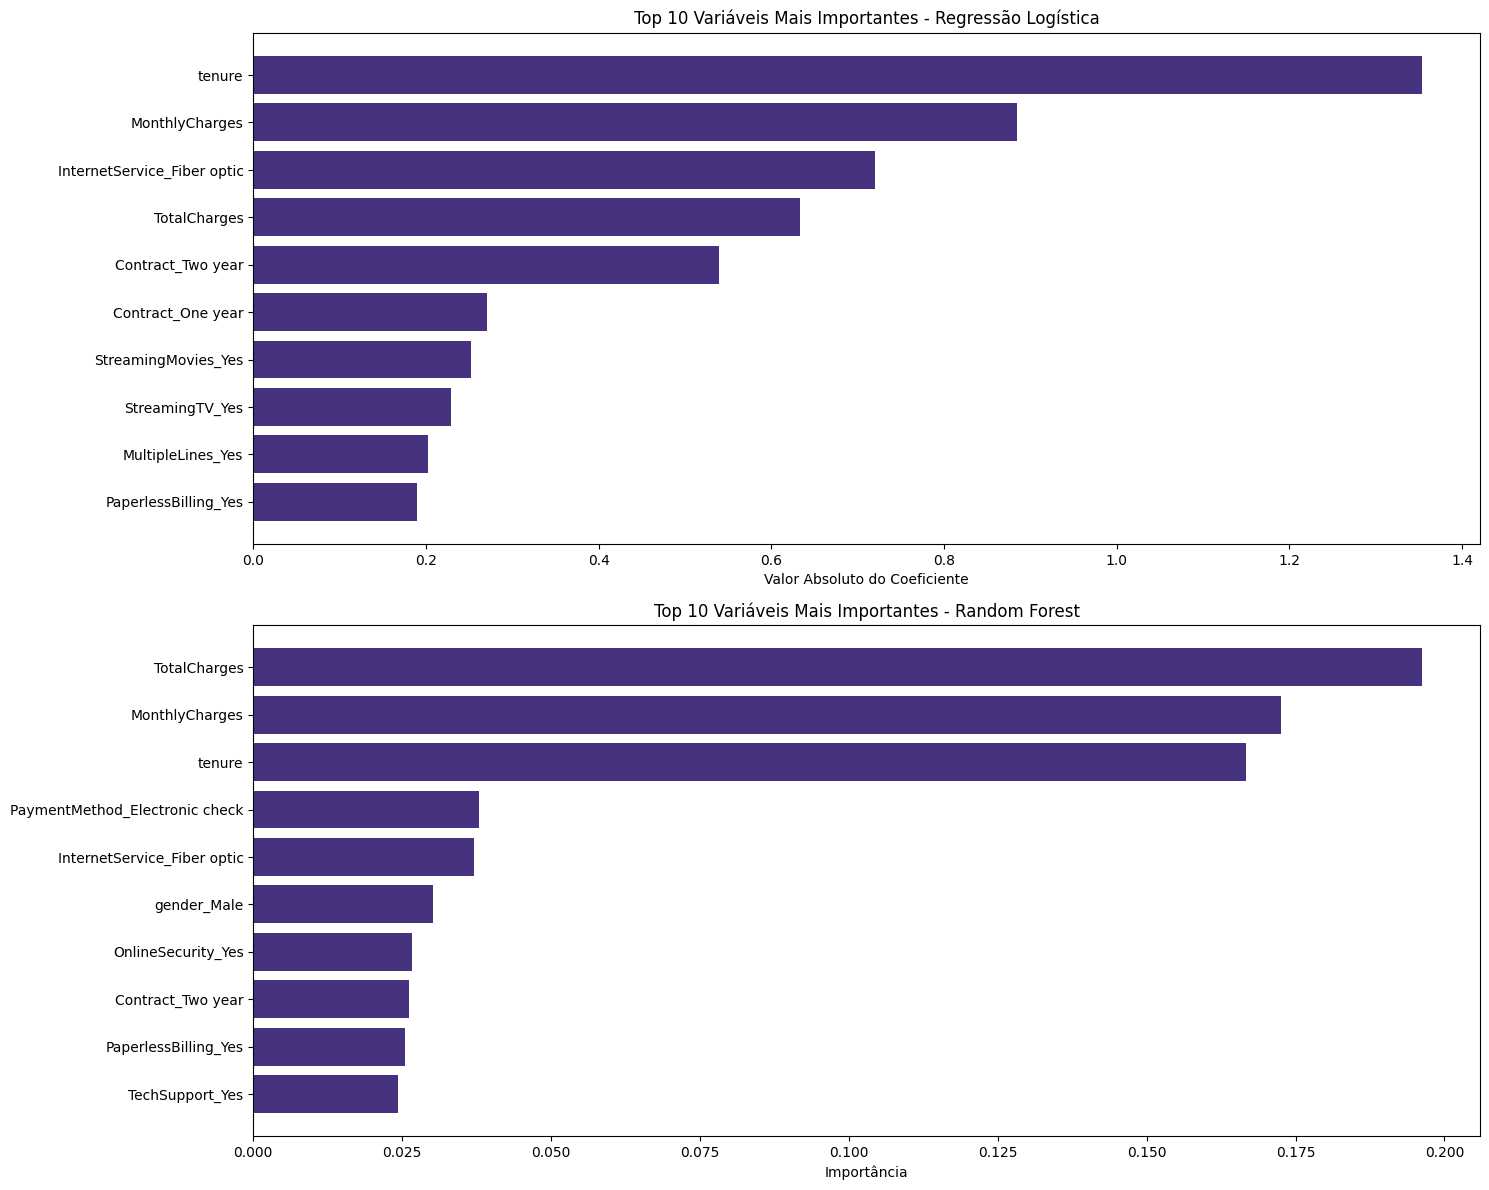

In [18]:
# Visualizar importância das variáveis
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Regressão Logística
top_10_log_reg = log_reg_coef_sorted.head(10)
axes[0].barh(range(len(top_10_log_reg)), top_10_log_reg['Abs_Coefficient'])
axes[0].set_yticks(range(len(top_10_log_reg)))
axes[0].set_yticklabels(top_10_log_reg['Feature'])
axes[0].set_xlabel('Valor Absoluto do Coeficiente')
axes[0].set_title('Top 10 Variáveis Mais Importantes - Regressão Logística')
axes[0].invert_yaxis()

# Random Forest
top_10_rf = rf_importance_sorted.head(10)
axes[1].barh(range(len(top_10_rf)), top_10_rf['Importance'])
axes[1].set_yticks(range(len(top_10_rf)))
axes[1].set_yticklabels(top_10_rf['Feature'])
axes[1].set_xlabel('Importância')
axes[1].set_title('Top 10 Variáveis Mais Importantes - Random Forest')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Conclusões e Insights

### Principais Achados:

1. **Desempenho dos Modelos:**
   - A Regressão Logística apresentou melhor desempenho geral
   - Ambos os modelos mostraram boa capacidade preditiva

2. **Fatores Mais Importantes para Churn:**
   - **Tenure (tempo de contrato):** Clientes com menor tempo de permanência têm maior propensão ao churn
   - **MonthlyCharges:** Valor das cobranças mensais influencia significativamente
   - **InternetService_Fiber optic:** Clientes com fibra óptica apresentam maior taxa de churn
   - **TotalCharges:** Valor total gasto também é um fator importante

3. **Recomendações Estratégicas:**
   - Focar na retenção de clientes novos (primeiros meses)
   - Investigar problemas com o serviço de fibra óptica
   - Desenvolver estratégias de pricing mais competitivas
   - Incentivar contratos de longo prazo
   - Promover serviços adicionais que aumentam a fidelização

In [19]:
# Salvar os resultados finais
print("Salvando resultados...")

# Salvar dados processados
df_encoded.to_csv('../data/processed_data.csv', index=False)

# Salvar comparação dos modelos
models_comparison.to_csv('../reports/models_comparison.csv', index=False)

# Salvar importância das variáveis
log_reg_coef_sorted.to_csv('../reports/logistic_regression_coefficients.csv', index=False)
rf_importance_sorted.to_csv('../reports/random_forest_importance.csv', index=False)

print("Análise completa! Todos os resultados foram salvos.")

Salvando resultados...
Análise completa! Todos os resultados foram salvos.
